In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# load necessary machine learning packages
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

<h2>Convolutional Neural Networks</h2>

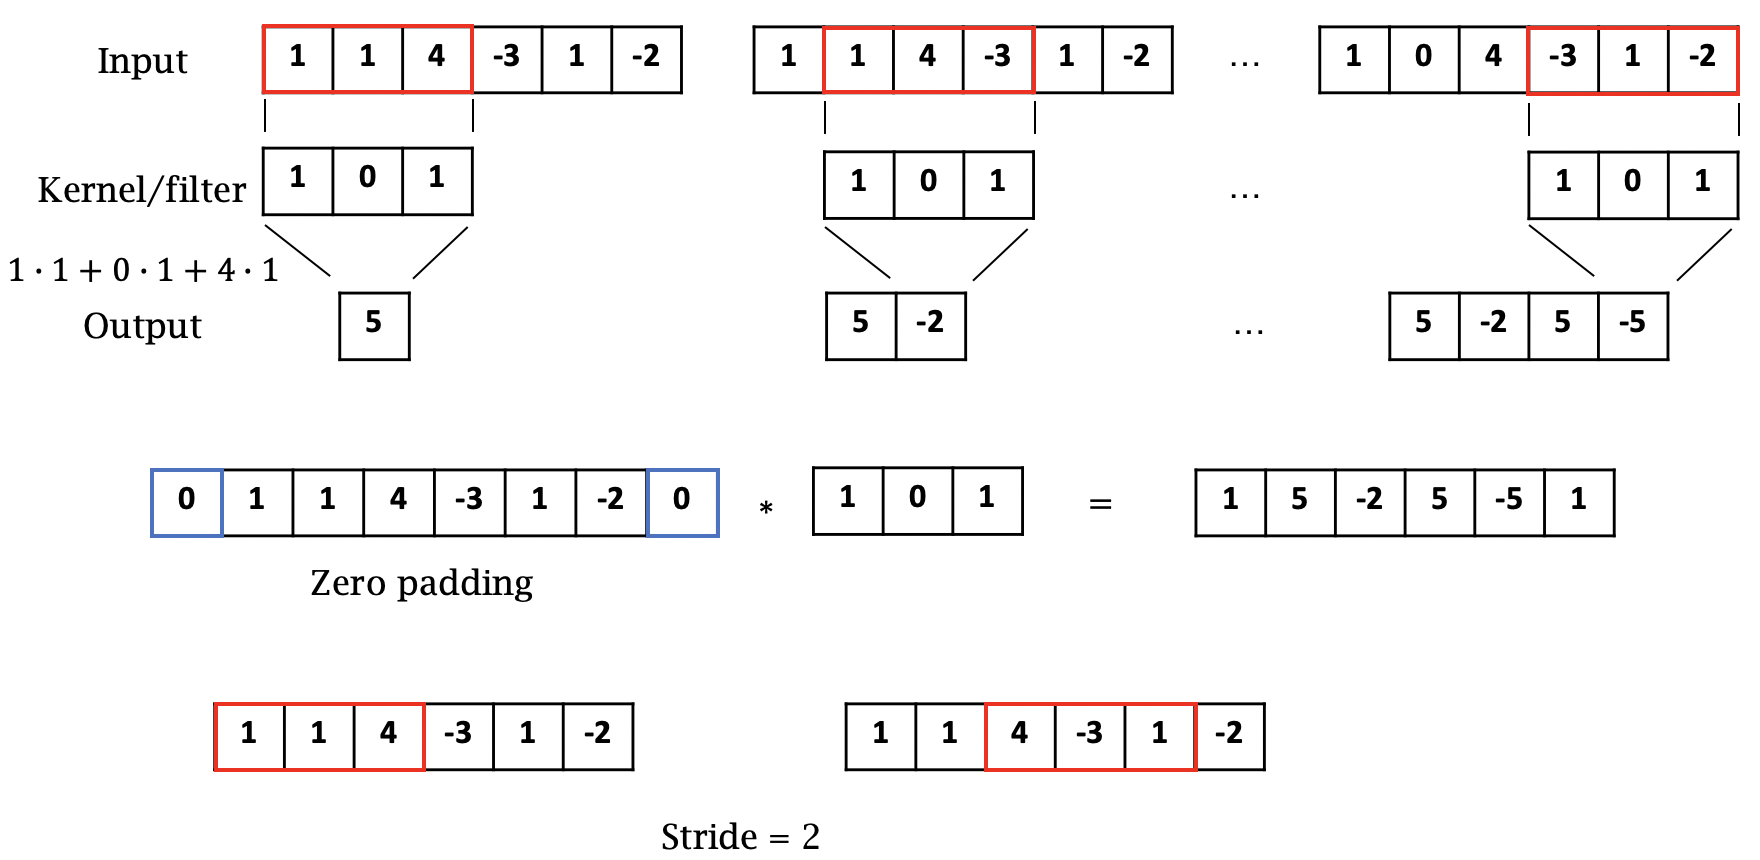

Output size = (input size - kernel size + 2*padding)/stride +1

In [ ]:
# define tensor of random numbers
input_data = torch.randn(1,1,16)
print(input_data)
print(input_data.shape)

tensor([[[ 0.3826, -0.1174,  1.0100,  0.3169, -0.8876, -0.4773, -0.5389,
          -0.1763, -1.4480,  0.4771, -0.3416, -0.1617, -0.7420,  0.0174,
          -1.7893, -0.1734]]])
torch.Size([1, 1, 16])


In [ ]:
conv_layer = nn.Conv1d(1, 1, kernel_size=5, padding=2)
convolution = conv_layer(input_data)
print(convolution)
print(convolution.shape)

tensor([[[ 0.8850,  0.1229,  0.2961, -0.1798, -0.3515,  0.4697, -0.3733,
           0.7753, -0.3942,  1.0411, -0.4205,  0.4593, -0.7374,  0.6860,
          -0.4021,  0.9964]]], grad_fn=<SqueezeBackward1>)
torch.Size([1, 1, 16])


<h3> 2D Convolutions

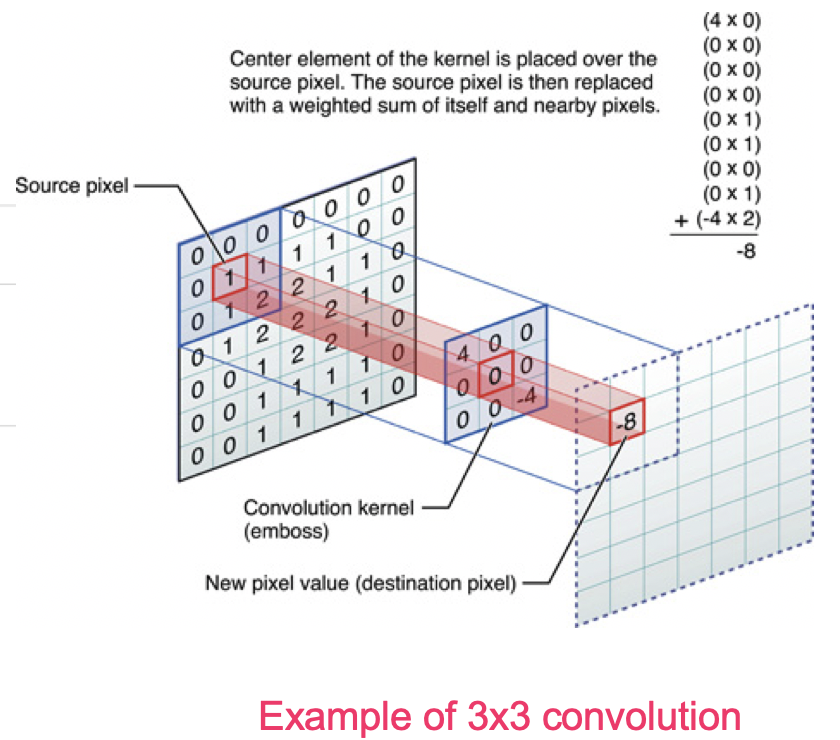

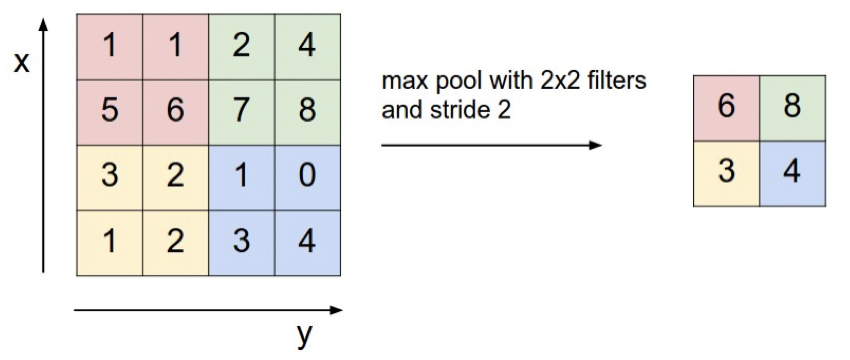

In [ ]:
im = Image.open("figures/sagrada-familia.jpeg")
data = np.asarray(im)
plt.figure(figsize=(8,12))
plt.imshow(data)

FileNotFoundError: ignored

In [ ]:
print(data.shape)

(1773, 1200, 3)


In [ ]:
#RGB values [0,225]
print(data)

[[[203 207 232]
  [203 207 232]
  [203 207 232]
  ...
  [ 87 123 211]
  [ 87 124 213]
  [ 90 130 218]]

 [[205 209 234]
  [204 208 233]
  [203 207 232]
  ...
  [ 87 123 211]
  [ 84 121 210]
  [ 87 127 215]]

 [[207 211 236]
  [206 210 235]
  [205 209 234]
  ...
  [ 87 123 209]
  [ 83 120 208]
  [ 86 123 212]]

 ...

 [[ 21  18  11]
  [ 19  16   9]
  [ 19  16   9]
  ...
  [ 98  83  40]
  [ 98  84  39]
  [ 93  79  34]]

 [[ 21  18  11]
  [ 18  15   8]
  [ 18  15   8]
  ...
  [ 82  68  29]
  [ 81  68  26]
  [ 73  60  18]]

 [[ 21  18  11]
  [ 19  16   9]
  [ 18  15   8]
  ...
  [ 66  54  16]
  [ 66  54  16]
  [ 59  47   7]]]


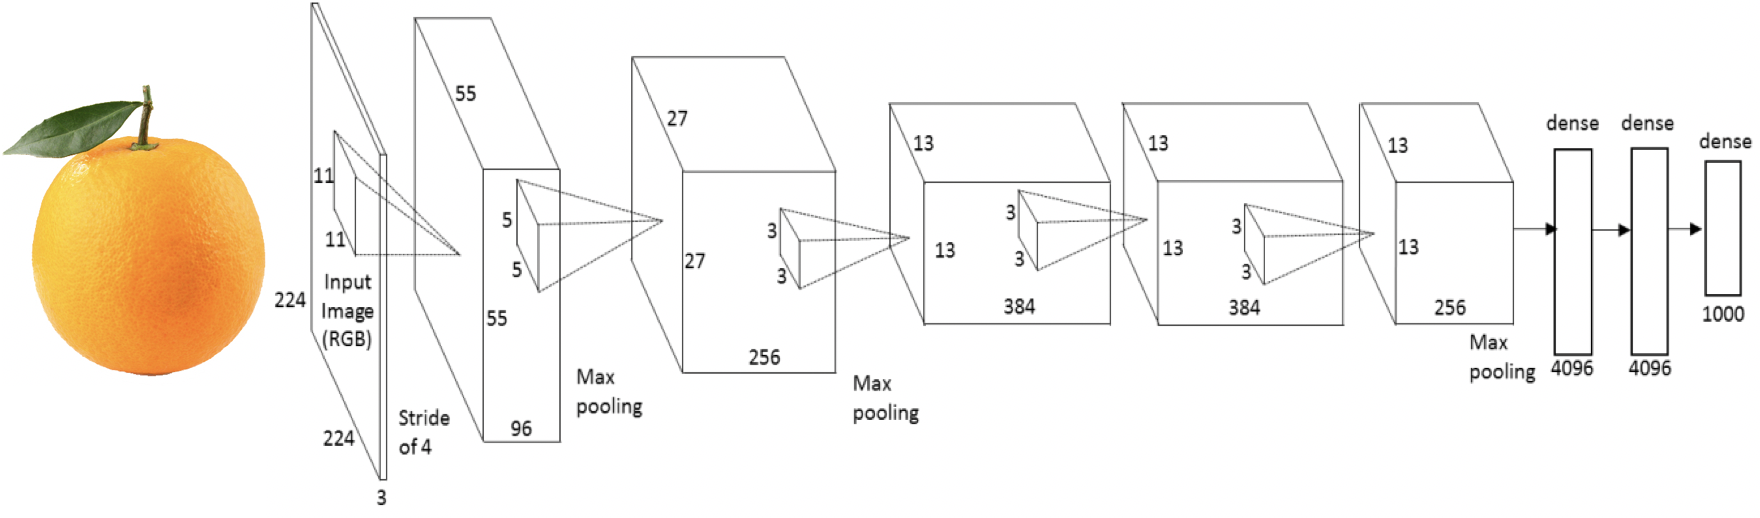

<h3>MNIST dataset</h3>
28x28 pixels

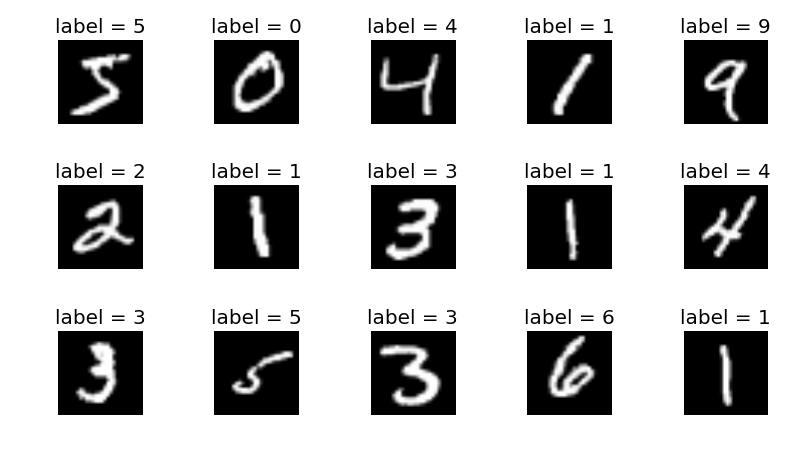

# **Build and train a Neural Network to classify images**

In [ ]:
# download and load data
batch_size = 512

# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transforms.Compose([
                                                transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                ])), batch_size=batch_size, shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=False, transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), batch_size=batch_size, shuffle=True)

In [ ]:
iterable = iter(train_loader)
print(iterable.next()[0].shape)
print(iterable.next()[1].shape)

torch.Size([512, 1, 28, 28])
torch.Size([512])


In [ ]:
### This defines the neural network
# It has 5 convolutional layers (nn.Conv2d) and 1 linear layer (nn.Linear)
# The function forward() computes the forward feed of x composing all the layers

# hyperparameters
learning_rate = 10e-3
weight_decay = 10e-5
n_epochs = 10

# neural network
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.avg = nn.AdaptiveAvgPool2d(4)
    self.fc = nn.Linear(1024,10)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = torch.relu(self.conv1(x))
    x = torch.relu(self.conv2(x))
    x = self.maxpool(x)
    x = self.bn1(x)
    x = torch.relu(self.conv3(x))
    x = torch.relu(self.conv4(x))
    x = torch.relu(self.conv5(x))
    x = self.maxpool(x)
    x = self.bn2(x)
    x = self.avg(x)
    x = x.view(-1,1024)
    x = self.fc(x)
    x = self.softmax(x)
    return(x)

In [ ]:
# use gpu if available, otherwise use cpu to run computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

In [ ]:
# Define optimizer and loss function
# Adam optimizer is a variation of Stochastic Gradient Descent
# The loss function used is the cross entropy

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_function = nn.CrossEntropyLoss()

In [ ]:
# Train function
def train(epochs, model, dataloader, testloader, optimizer, loss_function):
  for epoch in range(epochs):
    loss_epoch = np.array([])
    correct, total = (0,0)
    for data, labels in dataloader:
      input_data = Variable(data).to(device)
      labels = labels.to(device)
      predict = model(input_data)
      loss = loss_function(predict, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_epoch = np.append(loss_epoch, loss.item())
      for i, out in enumerate(predict):
        pred = torch.argmax(out)
        if pred == labels[i]:
          correct+=1
        total+=1

      for data, labels = 
    accuracy = correct/total
    print('epoch [{}/{}], training loss:{:.4f}, accuracy:{:.4f}'.format(epoch+1, epochs, np.mean(loss_epoch), accuracy))

In [ ]:
train(n_epochs, model, train_loader, optimizer, loss_function)

epoch [1/10], training loss:0.1941, accuracy:0.9364
epoch [2/10], training loss:0.0427, accuracy:0.9866
epoch [3/10], training loss:0.0328, accuracy:0.9895
epoch [4/10], training loss:0.0269, accuracy:0.9916
epoch [5/10], training loss:0.0240, accuracy:0.9924
epoch [6/10], training loss:0.0213, accuracy:0.9933
epoch [7/10], training loss:0.0200, accuracy:0.9936
epoch [8/10], training loss:0.0217, accuracy:0.9928
epoch [9/10], training loss:0.0211, accuracy:0.9930
epoch [10/10], training loss:0.0175, accuracy:0.9943


# Exercise

Create a neural network with maximum accuracy on the .

* Things you can modify: change 

* The total number of parameters has to be less than 50000. To check the current number of parameters, use: ```sum([p.numel() for p in model.parameters()])``` 

*  

Things you need to know:

* Add a layer: to do so, 
 *  Linear: ```nn.Linear```
 *  Convolutional: ```nn.Conv2d```



In [ ]:
sum([p.numel() for p in model.parameters()])

45530